In [28]:
import os
import gc
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
torch.set_num_threads(3)
import numpy as np

#remember to set these variables before running
n_epochs = 50
model = models.resnet18(pretrained=True)
model_name = "Resnet18"

In [29]:
import zipfile
from google.colab import drive

#Only use if running on google colab

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/EGFR.zip", 'r')
zip_ref.extractall("")
zip_ref.close()

ModuleNotFoundError: No module named 'google.colab'

In [30]:
traindir = os.getcwd() + "\\EGFR\\Dataset"
testdir = os.getcwd() + "\\EGFR\\val_Dataset"

#transformations
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      torchvision.transforms.Normalize(
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225],
    ),
                                      ])


In [31]:
#datasets
train_data = datasets.ImageFolder(traindir,transform=train_transforms)
test_data = datasets.ImageFolder(testdir,transform=test_transforms)

print(f"Found {len(train_data)} samples for training")
print(f"Found {len(test_data)} samples for validation")

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = False, batch_size=16)
valloader = torch.utils.data.DataLoader(test_data, shuffle = False, batch_size=16)

Found 25620 samples for training
Found 10985 samples for validation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


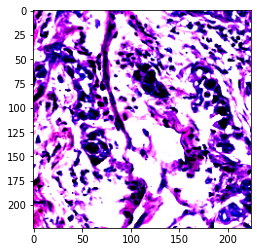

Label: 0
C:\Users\User\OneDrive\Documents\School\Project-Work\CenTaD\EGFR\Dataset\EGFR\TCGA-05-4402_1003.jpeg


In [32]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]
label = train_labels[0]
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
sample_fname, _ = trainloader.dataset.samples[0]
print(sample_fname)

In [33]:
sample_fname, _ = trainloader.dataset.samples[2]
print(sample_fname)

C:\Users\User\OneDrive\Documents\School\Project-Work\CenTaD\EGFR\Dataset\EGFR\TCGA-05-4402_1005.jpeg


In [34]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()
    del yhat
    gc.collect()
    
    return loss
  return train_step

In [35]:
if os.path.exists("Losses"):
  print("Losses directory is present")
else:
  print("Creating losses directory")
  os.mkdir("Losses")

if os.path.exists("Models"):
  print("Models directory is present")
else:
  print("Creating models directory")
  os.mkdir("Models")

if os.path.exists("Results"):
  print("Results directory is present")
else:
  print("Creating results directory")
  os.mkdir("Results")

Losses directory is present
Models directory is present
Results directory is present


In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Currently using {device}")

#freeze all params
for params in model.parameters():
  params.requires_grad_ = False

#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

Currently using cpu


In [37]:
#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [38]:
def plot():
  training_losses = []
  validation_losses = []
  epochs_list = []

  for i in epoch_train_losses:
      training_losses.append(i.item())

  for i in epoch_test_losses:
      validation_losses.append(i.item())
      
  for i in range(len(training_losses)):
      epochs_list.append(i)
      
  plt.clf()
  plt.plot(epochs_list, training_losses)
  plt.ylabel('Training loss')
  plt.xlabel('Epoch')
  plt.show()
  with open(f"Losses/{model_name}_train.txt", "w") as handler:
    handler.write(str(training_losses))
  plt.savefig(f"Losses/{model_name}_train.png")

  plt.clf()
  plt.plot(epochs_list, validation_losses)
  plt.ylabel('Validation loss')
  plt.xlabel('Epoch')
  plt.show()
  with open(f"Losses/{model_name}_val.txt", "w") as handler:
    handler.write(str(validation_losses))
  plt.savefig(f"Losses/{model_name}_val.png")

In [ ]:
losses = []
val_losses = []

epoch_train_losses = []
epoch_test_losses = []

early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device) #move to gpu


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)
    #gc.collect()
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in tqdm(valloader, total = len(valloader)):
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(valloader)
      val_losses.append(val_loss.item())
      del yhat


    epoch_test_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    plot()
    gc.collect()

    best_loss = min(epoch_test_losses)
    
    #save best model
    if cum_loss <= best_loss:
        
      best_model_wts = model.state_dict()
    torch.save(model.state_dict(), f"Models/{model_name}.pth")
    
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)

 54%|██████████████████████████████████████████▉                                    | 870/1602 [30:22<27:03,  2.22s/it]

In [ ]:
accumulated_egfr = {}
accumulated_non = {}
totalt = {}
WSIs = []
def test(): 
  # Load the model that we saved at the end of the training loop 
  path = f"{os.getcwd()}/Models/{model_name}.pth" 
  model.load_state_dict(torch.load(path, map_location = torch.device(device)))
  with open(path, "rb") as handler:
    print(f"Size of model is {len(handler.read())} bytes")
  res = ""

  running_accuracy = 0 
  total = 0 
  tp = tn = fp = fn = 0
  testloader = trainloader #to change to actual test data

  with torch.no_grad(): 
    it = 0
    for data in tqdm(testloader, total = len(testloader)): 
      inputs, outputs = data 
      #print(inputs)
      inputs = inputs.to(device)
      
      outputs = outputs.to(device)
      predicted_outputs = model(inputs)
      predicted_outputs = torch.sigmoid(predicted_outputs)
      #sample_fname, _ = testloader.dataset.samples[x]
      #print(sample_fname)
      for i in range(0, outputs.size(0)):
        prediction = predicted_outputs[i]
        actual = outputs[i]
        sample_fname, _ = testloader.dataset.samples[it]
        
        if prediction > 0.5:
            print(prediction, actual)
        it += 1
        new = ""
        last = 0
        for j in range(len(sample_fname)):
            if sample_fname[j] == "_":
                last = j
        for j in range(len(sample_fname)):
            if sample_fname[j] == "_" and j == last:
                break
            new += sample_fname[j]
        #print(new)
        
        newWSI = ""
        for j in range(len(sample_fname)):
            if sample_fname[j] == "_" and j == last:
                newWSI += f"_{sample_fname[j+1]}"
                break
            newWSI += sample_fname[j]
            
        if newWSI not in WSIs:
            WSIs.append(newWSI)
        
        
        if new in totalt:
            totalt[new] += 1
        else:
            totalt[new] = 1
        if actual == 0:
            if new in accumulated_egfr:
                accumulated_egfr[new] += prediction
            else:
                accumulated_egfr[new] = prediction
        else:
            if new in accumulated_non:
                accumulated_non[new] += prediction
            else:
                accumulated_non[new] = prediction

    #print(accumulated_egfr.values())
    #print(accumulated_non.values())

test()
print(WSIs)

In [18]:
for i in WSIs:
    print(i)
print(len(WSIs))

C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4402_1
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4402_2
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4402_3
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4402_4
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4402_5
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4402_6
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4402_7
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4402_8
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4402_9
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4410_0
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4410_1
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4410_2
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4410_3
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\EGFR\TCGA-05-4410_4
C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\

In [12]:

    
datasetnew = {}
for key in accumulated_egfr.keys():
    datasetnew[key] = float(accumulated_egfr[key] / totalt[key])
    print(key[-12:], end = "\t")
    print(totalt[key], end = "\t")
    print("", end = "\t")
    print("1")
for key in accumulated_non.keys():
    datasetnew[key] = float(accumulated_non[key] / totalt[key])
    print(key[-12:], end = "\t")
    print(totalt[key], end = "\t")
    print("", end = "\t")
    print("0")
for i in datasetnew.items():
    print(i)
    


TCGA-05-4402	1037		1
TCGA-05-4410	601		1
TCGA-38-4628	526		1
TCGA-44-2661	1322		1
TCGA-44-5645	749		1
TCGA-49-4490	545		1
TCGA-49-4501	1148		1
TCGA-50-6591	736		1
TCGA-55-6981	462		1
TCGA-55-8096	273		1
TCGA-55-8206	310		1
TCGA-55-A57B	306		1
TCGA-62-8394	413		1
TCGA-67-3770	385		1
TCGA-69-7765	329		1
TCGA-75-6207	315		1
TCGA-78-7155	473		1
TCGA-78-7158	787		1
TCGA-86-8280	4900		1
TCGA-91-8496	160		1
TCGA-95-7947	198		1
TCGA-97-8177	371		1
TCGA-97-A4M1	884		1
TCGA-MP-A4SW	361		1
TCGA-05-4402	467		0
TCGA-38-4628	527		0
TCGA-49-4490	544		0
TCGA-49-4501	1148		0
TCGA-50-6591	331		0
TCGA-55-6981	238		0
TCGA-55-A57B	308		0
TCGA-62-8394	413		0
TCGA-69-7765	326		0
TCGA-75-6207	154		0
TCGA-78-7155	157		0
TCGA-78-7158	786		0
TCGA-86-8280	1751		0
TCGA-91-8496	160		0
TCGA-95-7947	201		0
TCGA-MP-A4T9	395		0
TCGA-O1-A52J	123		0
('C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\\EGFR\\TCGA-05-4402', 0.3097665309906006)
('C:/Users/Lai Jun Yu/Downloads/EGFR/EGFR/Dataset\\EGFR\\TCGA-05-4410', 0.30927926

In [83]:
import torch
from torch.autograd import Variable
from torch.nn import functional as F
x_data = Variable(torch.Tensor([[0.37205323576927185], [0.2899649441242218], [0.6954780220985413], [0.16500432789325714], [0.17463812232017517], [0.5623327493667603], [0.5869036912918091], [0.5632336139678955], [0.5206925868988037], [0.37964949011802673], [0.22762790322303772], [0.5749718546867371], [0.5874749422073364], [0.3084607720375061], [0.5524044632911682], [0.5515181422233582], [0.5038177967071533], [0.6300205588340759], [0.3640299439430237], [0.37736159563064575], [0.6399526000022888], [0.21301738917827606], [0.2783263027667999], [0.4599112868309021], [0.4094010591506958], [0.6952522993087769], [0.579990029335022], [0.5981982946395874], [0.6708260178565979], [0.5622238516807556], [0.5961835384368896], [0.6049429774284363], [0.5417302250862122], [0.58616042137146], [0.5630359053611755], [0.646808385848999], [0.6907274127006531], [0.39761829376220703], [0.6216567754745483], [0.6640619039535522], [0.5529825091362]]))
y_data = Variable(torch.Tensor([[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]))

X_testing = Variable(torch.Tensor([[0.388005793094635], [0.312065452337265], [0.708579421043396], [0.16745366156101227], [0.20195122063159943], [0.5654458403587341], [0.5926942229270935], [0.6129453182220459], [0.5230876803398132], [0.430520623922348], [0.22202268242835999], [0.5961989760398865], [0.5847880244255066], [0.3080741763114929], [0.5485895276069641], [0.5503789186477661], [0.5482227206230164], [0.6484061479568481], [0.37175044417381287], [0.3980584144592285], [0.5467280745506287], [0.2120809704065323], [0.31326404213905334], [0.48170989751815796], [0.4152951240539551], [0.7033922076225281], [0.5808889269828796], [0.5885471105575562], [0.6709027886390686], [0.5579226016998291], [0.5720942616462708], [0.5696393847465515], [0.5537814497947693], [0.5817751884460449], [0.5423876643180847], [0.6286444664001465], [0.660331666469574], [0.3931173086166382], [0.6439269781112671], [0.67128986120224], [0.536640465259552]]))
Y_testing = Variable(torch.Tensor([[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]))


In [49]:
class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(1, 1)
     def forward(self, x):
        y_pred = F.sigmoid(self.linear(x))
        return y_pred
model = LogisticRegression()
criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_list = []
for epoch in tqdm(range(500000), total = 500000):
    model.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_data)
    # Compute Loss
    loss = criterion(y_pred, y_data)
    loss_list.append(loss)
    # Backward pass
    loss.backward()
    optimizer.step()
    torch.save(model.state_dict(), f"Models/logreg.pth")


100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [06:13<00:00, 1339.45it/s]


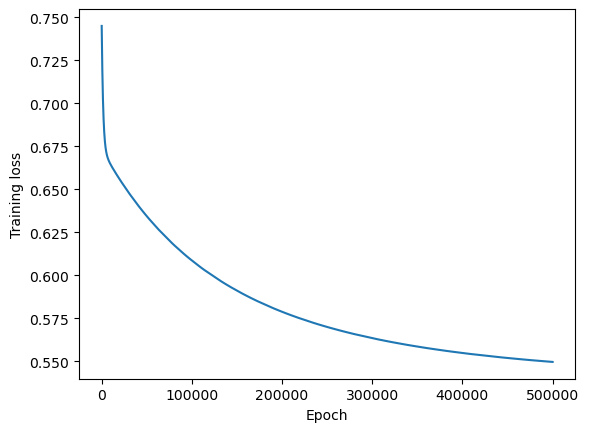

<Figure size 640x480 with 0 Axes>

In [50]:
def plot():
  training_losses = []
  validation_losses = []
  epochs_list = []

  for i in loss_list:
      training_losses.append(i.item())


      
  for i in range(len(training_losses)):
      epochs_list.append(i)
      
  plt.clf()
  plt.plot(epochs_list, training_losses)
  plt.ylabel('Training loss')
  plt.xlabel('Epoch')
  plt.show()
  #with open(f"Losses/{model_name}_train.txt", "w") as handler:
    #handler.write(str(training_losses))
  plt.savefig(f"{os.getcwd()}\\Losses/logistic.png")
plot()

In [85]:

from sklearn.metrics import roc_auc_score
model.eval()
with torch.no_grad(): 
    
    it = 0
    
    predictions = model(X_testing)
    #predictions = torch.sigmoid(predictions)
    correct = 0
    #print(predictions)
    
    score = roc_auc_score(Y_testing, predictions)
    print(f"ROC AUC: {score:.4f}")
    for i in range(len(predictions)):
        if predictions[i] > 0.5:
            predictions[i] = 1
        else:
            predictions[i] = 0
    for i in range(len(predictions)):
        if predictions[i] == Y_testing[i]:
            correct += 1
            
print(correct/len(predictions))



correctest = 0
for i in range(len(X_testing)):
    if X_testing[i] > 0.5:
        X_testing[i] = 1
    else:
        X_testing[i] = 0
        
    if X_testing[i] == Y_testing[i]:
        correctest += 1
        
print(correctest/len(X_testing))
print(len(X_testing), len(x_data))


ROC AUC: 0.7500
0.6829268292682927
0.6585365853658537
41 41


In [ ]:
class Binary_Classifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
model=Binary_Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
train_losses = []
for epoch in range(1, 15):
    train_loss = 0.0
    model.train()
    for data, target in train_loader:
  
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        #backward-pass
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Update the Training loss
        train_loss += loss.item() * data.size(0)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x58320 and 720x1024)